<a href="https://colab.research.google.com/github/p25-c4/plate_project/blob/main/scale_randomforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!rm ~/.cache/matplotlib -rf

Selecting previously unselected package fonts-nanum.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [1]:
# 데이터 구성:Series, DataFrame
import pandas as pd
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
#분류 Random Forest
from sklearn.ensemble import RandomForestClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler

# 팔레트 설정
palette = sns.color_palette('Paired')
colors = sns.color_palette('Pastel1')
sns.set_palette('Pastel1')


In [2]:
# 그래프 한글폰트 적용:맑은 고딕
matplotlib.rc("font", family = "NanumGothic")
# 그래프 (-) 기호 표시
matplotlib.rc("axes", unicode_minus = False)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 데이터 불러오기
df_raw = pd.read_csv("/content/drive/MyDrive/BigData/real_final_scale.csv")
df_raw.head()

,scale,spec_country,steel_kind,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,day_yn,purpose
0,0,미국,T,32,3700,15100,1,1,1144,116,1133,59,259,TMCP(온도제어),934,8,주간,선체구조용(조선용)
1,0,미국,T,32,3700,15100,1,2,1144,122,1135,53,238,TMCP(온도제어),937,8,주간,선체구조용(조선용)
2,0,영국,T,33,3600,19200,2,1,1129,116,1121,55,258,TMCP(온도제어),889,8,주간,선체구조용(조선용)
3,0,영국,T,33,3600,19200,2,2,1152,125,1127,68,266,TMCP(온도제어),885,8,주간,선체구조용(조선용)
4,0,프랑스,T,38,3100,13300,3,1,1140,134,1128,48,246,TMCP(온도제어),873,8,주간,선체구조용(조선용)


In [5]:
df_raw['fur_no'] = df_raw['fur_no'].astype(str)
df_raw['fur_input_row'] = df_raw['fur_input_row'].astype(str)

In [6]:
df_raw_x = df_raw.drop('scale', axis=1)
df_raw_x_1 = df_raw.drop(["scale",'steel_kind', 'day_yn', 'rolling_method'], axis=1)
df_raw_x_2 = df_raw[['steel_kind', 'day_yn', 'rolling_method', 'fur_input_row']]  # 범주가 2개인 자료는 따로 dummy화
df_raw_y = df_raw['scale']

In [7]:
# 범주형 변수 선택 : select_dtypes="object"
df_raw_x_char_1 = df_raw_x_1.select_dtypes(include = "object")
df_raw_x_char_2 = df_raw_x_2.select_dtypes(include = "object")
df_raw_x_char = pd.concat([df_raw_x_char_1, df_raw_x_char_2], axis=1)

# get_dummies: 범주형 변수에 대한 더미변환
df_x_dummy_1 = pd.get_dummies(df_raw_x_char_1)
df_x_dummy_2 = pd.get_dummies(df_raw_x_char_2, drop_first=True) # 범주가 2개인 자료는 따로 dummy화
df_x_dummy = pd.concat([df_x_dummy_1, df_x_dummy_2], axis=1)


# 연속형 변수 선택 : select_dtypes="object" 제외
df_raw_x_num = df_raw_x.select_dtypes(exclude = "object")

# 변수명 저장
v_feature_names = df_raw_x_num.columns

# StandardScaler 적용
scaler = StandardScaler()
df_x_scaled = scaler.fit_transform(df_raw_x_num)
df_x_scaled = pd.DataFrame(df_x_scaled, columns=v_feature_names)

# 원래 연속형(df_raw_x_num) + dummy된 범주형(df_x_dummy)
df_x_raw_dummy = df_raw_x_num.join(df_x_dummy)
display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:",df_x_raw_dummy.head(3))

# scale된 연속형(df_x_scaled)+ dummy된 범주형(df_x_dummy)
df_x_scale_dummy = df_x_scaled.join(df_x_dummy)
display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:",df_x_scale_dummy.head(3))

# scale된 연속형(df_x_scaled) + 원래 범주형(df_raw_x_char)
df_x_scale_raw = df_x_scaled.join(df_raw_x_char)
display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_x_scale_raw.head(3))

'원래 연속형+ Dummied 범주형...DT/RF/GB 용:'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,...,fur_input_row_1,fur_input_row_2,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어),fur_input_row_2
0,32,3700,15100,1144,116,1133,59,259,934,8,...,1,0,0,1,0,0,1,1,1,0
1,32,3700,15100,1144,122,1135,53,238,937,8,...,0,1,0,1,0,0,1,1,1,1
2,33,3600,19200,1129,116,1121,55,258,889,8,...,1,0,0,1,0,0,1,1,1,0


'Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,...,fur_input_row_1,fur_input_row_2,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어),fur_input_row_2
0,0.298839,1.765880,-1.561273,-0.623951,1.13104,-1.034421,-0.615879,0.534990,-0.103218,-0.342411,...,1,0,0,1,0,0,1,1,1,0
1,0.298839,1.765880,-1.561273,-0.623951,1.35857,-0.918753,-0.906940,-0.017416,-0.056516,-0.342411,...,0,1,0,1,0,0,1,1,1,1
2,0.354957,1.562785,-1.265674,-1.333010,1.13104,-1.728433,-0.809920,0.508684,-0.803747,-0.342411,...,1,0,0,1,0,0,1,1,1,0


'Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,spec_country,fur_no,fur_input_row,purpose,steel_kind,day_yn,rolling_method,fur_input_row
0,0.298839,1.765880,-1.561273,-0.623951,1.13104,-1.034421,-0.615879,0.534990,-0.103218,-0.342411,미국,1,1,선체구조용(조선용),T,주간,TMCP(온도제어),1
1,0.298839,1.765880,-1.561273,-0.623951,1.35857,-0.918753,-0.906940,-0.017416,-0.056516,-0.342411,미국,1,2,선체구조용(조선용),T,주간,TMCP(온도제어),2
2,0.354957,1.562785,-1.265674,-1.333010,1.13104,-1.728433,-0.809920,0.508684,-0.803747,-0.342411,영국,2,1,선체구조용(조선용),T,주간,TMCP(온도제어),1


In [8]:
## train_test_split
# 원래 연속형+ Dummied 범주형...DT/RF/GB 용:df_x_raw_dummy
df_train_x_rd, df_test_x_rd, df_train_y, df_test_y = train_test_split(df_x_raw_dummy, df_raw_y
                                    , test_size = 0.3, stratify = df_x_raw_dummy["steel_kind_T"], random_state=2024)

# display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:", df_train_x_rd.head())

# # 기계학습용 데이터(Scaled 연속형+ Dummied 범주형) 분할:df_x_scale_dummy
# df_train_x_sd, df_test_x_sd, df_train_y, df_test_y = train_test_split(df_x_scale_dummy, df_raw_y
#                                     , test_size = 0.2, stratify = df_x_raw_dummy["steel_kind_T"], random_state=2024)

# display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:", df_train_x_sd.head())

# # 회귀분석용(표준화 회귀계수) 데이터(Scaled 연속형+ 원래 범주형) 분할:df_x_scale_raw
# df_train_x_reg, df_test_x_reg, df_train_y, df_test_y = train_test_split(df_x_scale_raw, df_raw_y
#                                     , test_size = 0.2, stratify = df_x_raw_dummy["steel_kind_T"], random_state=2024)

# display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_train_x_reg.head())


랜덤포레스트 -> rd 선택

In [9]:

df_raw_x = df_raw.drop('scale', axis=1)
df_raw_x_1 = df_raw.drop(["scale",'day_yn','steel_kind', 'day_yn', 'rolling_method'], axis=1)
df_raw_x_2 = df_raw[['steel_kind', 'day_yn', 'rolling_method']]  # 범주가 2개인 자료는 따로 dummy화
df_raw_y = df_raw['scale']

In [10]:
rf_uncust = RandomForestClassifier(random_state=2024)
rf_uncust.fit(df_train_x_rd, df_train_y)

# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(rf_uncust.score(df_train_x_rd, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(rf_uncust.score(df_test_x_rd, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.951


In [11]:
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    rf = RandomForestClassifier(n_estimators = v_n_estimators, random_state = 1234)
    rf.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(rf.score(df_train_x_rd, df_train_y))
    test_accuracy.append(rf.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

In [12]:
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.998,0.937
1,20,0.998,0.947
2,30,1.000,0.944
3,40,1.000,0.947
4,50,1.000,0.944
5,60,1.000,0.947
6,70,1.000,0.947
7,80,1.000,0.947
8,90,1.000,0.947
9,100,1.000,0.944


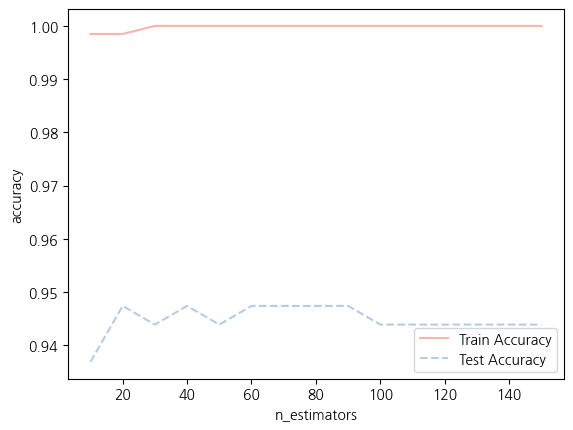

In [13]:
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("n_estimators"); plt.ylabel("accuracy")
plt.legend()

n_estimators = 20에서 Test accuracy가 제일 높고 Train set과 Test set의 차이가 가장 적으므로 n_estimators = 20으로 선정



In [14]:
oob_error = []

for v_n_estimator in range(5, 121):
    rf = RandomForestClassifier(n_estimators = v_n_estimator, oob_score = True, random_state= 1234)
    rf.fit(df_train_x_rd, df_train_y)
    oob_error.append(1 - rf.oob_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too fe

Text(0.5, 0, 'n_estimators')

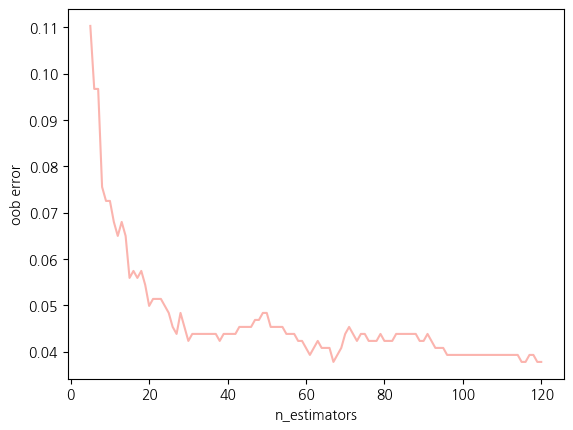

In [15]:
plt.plot(range(5, 121), oob_error)
plt.ylabel("oob error")
plt.xlabel("n_estimators")

In [16]:
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 16)]

for v_max_depth in para_depth:
    rf = RandomForestClassifier(max_depth = v_max_depth, n_estimators=20, random_state=2024)
    rf.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(rf.score(df_train_x_rd, df_train_y))
    test_accuracy.append(rf.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy


In [17]:
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.728,0.709
1,2,0.872,0.856
2,3,0.938,0.923
3,4,0.959,0.944
4,5,0.962,0.940
5,6,0.971,0.944
6,7,0.976,0.947
7,8,0.983,0.944
8,9,0.995,0.937
9,10,0.998,0.947


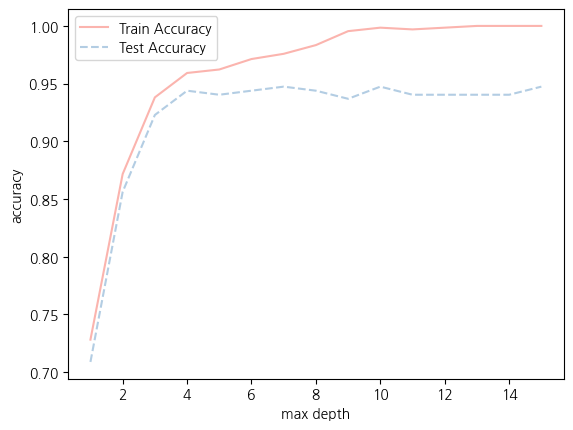

In [18]:
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("max depth"); plt.ylabel("accuracy")
plt.legend()

max_depth = 4 에서 Test accuracy가 최대이고 Train set과 Test set의 차이가 가장 적음. 그 중 최대값인 max_depth = 4 로 선정.

In [32]:
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수.
para_split = [n_split * 2 for n_split in range(1, 11)]

for v_min_samples_split in para_split:
    rf = RandomForestClassifier(min_samples_split = v_min_samples_split, max_depth=4,
                                n_estimators=20, random_state=2024)
    rf.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(rf.score(df_train_x_rd, df_train_y))
    test_accuracy.append(rf.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

In [33]:
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,2,0.959,0.944
1,4,0.959,0.944
2,6,0.958,0.940
3,8,0.959,0.944
4,10,0.959,0.944
5,12,0.959,0.944
6,14,0.961,0.944
7,16,0.959,0.944
8,18,0.959,0.944
9,20,0.959,0.944


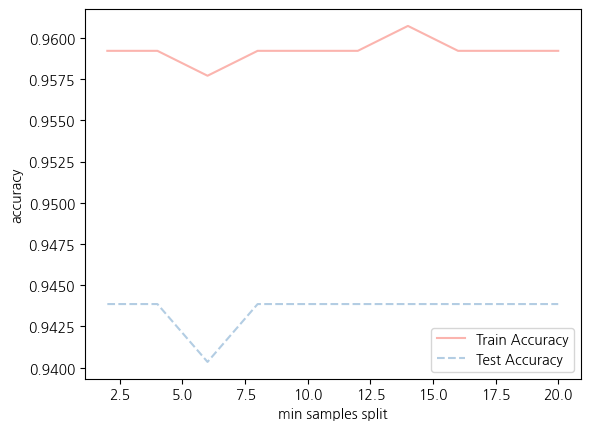

In [34]:
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min samples split"); plt.ylabel("accuracy")
plt.legend()

2에서 train set과 test set 의 차이가 적다. default 값인 2로 두기로 한다.  
min_samples_split 미지정

In [22]:
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 수 제한
para_leaf = [n_leaf  for n_leaf in range(1, 15)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestClassifier(min_samples_leaf = v_min_samples_leaf,
                                max_depth=4, n_estimators=20, random_state=2024)
    rf.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(rf.score(df_train_x_rd, df_train_y))
    test_accuracy.append(rf.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

In [23]:
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,1,0.959,0.944
1,2,0.955,0.937
2,3,0.959,0.940
3,4,0.958,0.940
4,5,0.961,0.947
5,6,0.959,0.944
6,7,0.961,0.944
7,8,0.956,0.944
8,9,0.956,0.944
9,10,0.959,0.940


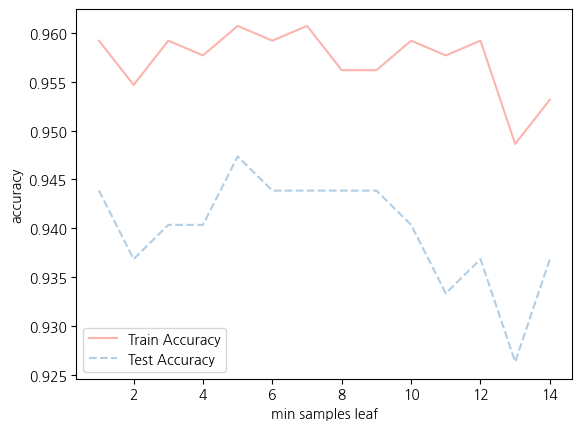

In [24]:
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min samples leaf"); plt.ylabel("accuracy")
plt.legend()

min_sample_leaf 8 Train set과 Test set의 차이가 가장 적은 min_sample_leaf = 8 선정

In [25]:
rf_final = RandomForestClassifier(min_samples_leaf=8, max_depth=4, n_estimators=20,
                                  random_state=2024)
rf_final.fit(df_train_x_rd, df_train_y)
# 평가
y_pred = rf_final.predict(df_test_x_rd)

# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(rf_final.score(df_train_x_rd, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}\n".format(rf_final.score(df_test_x_rd, df_test_y)))

# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits=3))

Accuracy on training set: 0.956
Accuracy on test set: 0.944

Confusion matrix: 
[[202   0]
 [ 16  67]]
              precision    recall  f1-score   support

           0      0.927     1.000     0.962       202
           1      1.000     0.807     0.893        83

    accuracy                          0.944       285
   macro avg      0.963     0.904     0.928       285
weighted avg      0.948     0.944     0.942       285



min_sample_leaf = 8, max_depth = 4, n_estimators = 20  
training set과 test set 의 정확도는 높지만 1(불량) 기준 f1-score가 0.893으로 다소 낮다.

In [27]:
v_feature_names = df_train_x_rd.columns
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_names
df_importance ["Importance"] = rf_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance10 = df_importance.head(10)
df_importance10 .round(3)

,Feature,Importance
8,rolling_temp,0.377
5,fur_soak_temp,0.108
1,pt_width,0.092
9,descaling_count,0.085
26,steel_kind_T,0.064
0,pt_thick,0.058
3,fur_heat_temp,0.054
2,pt_length,0.053
23,purpose_선체구조용(조선용),0.031
14,spec_country_일본,0.028


<ipython-input-42-98656e46fd20>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_importance10 .sort_values("Importance", ascending=True, inplace = True)


Text(0, 0.5, '설명변수')

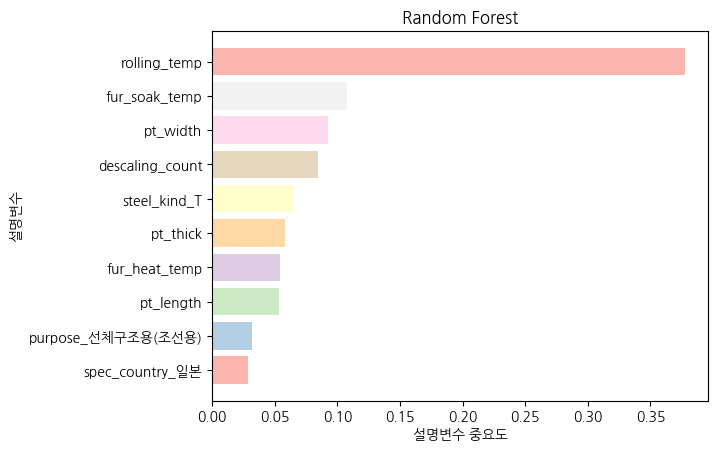

In [42]:
df_importance10 .sort_values("Importance", ascending=True, inplace = True)

palette = sns.color_palette("Pastel1", len(df_importance10))
coordinates = range(len(df_importance10 ))
plt.barh(y = coordinates, width = df_importance10 ["Importance"], color=palette)
plt.title("Random Forest")
plt.yticks(coordinates, df_importance10 ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

In [ ]:
estimator = RandomForestClassifier(n_estimators=20,random_state=2024)
# 구하고자 하는 parameter와 범위
param_grid = {"max_depth": para_depth,
              "min_samples_leaf": para_leaf}
# 정확도가 높은 최적 parameter 찾기
grid_rf = GridSearchCV(estimator, param_grid, scoring="f1", n_jobs = -1)
grid_rf.fit(df_train_x_rd, df_train_y)
print("best estimator model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))


best estimator model: 
RandomForestClassifier(max_depth=13, n_estimators=20, random_state=2024)

best parameter: 
{'max_depth': 13, 'min_samples_leaf': 1}

best score: 
0.931


In [ ]:
# 분류모델 통합 평가: 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 등
def eval_class_model(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)

    print('오차행렬:\n', confusion, '\n')
    print('정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1    : {:.4f}'.format(F1))
    print('AUC   : {:.4f}'.format(AUC))

In [41]:
grid_rf = RandomForestClassifier(max_depth=13, n_estimators=20)
grid_rf.fit(df_train_x_rd, df_train_y)
# 평가
y_pred = grid_rf.predict(df_test_x_rd)

# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(grid_rf.score(df_train_x_rd, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}\n".format(grid_rf.score(df_test_x_rd, df_test_y)))

# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set: 0.998
Accuracy on test set: 0.951

Confusion matrix: 
[[202   0]
 [ 14  69]]


정확도는 약간 높지만 과적합의 가능성이 있기 때문에 사용자가 지정한 파라미터 모델을 최종 모델로 선정한다.